# SENTIMENT ANALYSIS AND OPINION MINING PROJECT
## PUBLIC OPINION ON NEWS

https://island.ricerca.di.unimi.it/~alfio/shared/textsent/2020-21/projects.html

The New York Times Comments dataset (https://www.kaggle.com/aashita/nyt-comments?select=CommentsApril2017.csv) contains articles published on the New York Times and the comments they received from readers. <br>
The task of the project is to analyze, using the variables *editorsSelection*, *recommendations*, and *replyCount* as targets, the rate of success of a comment. This rate of success should be intepreted as a measure of how much controversial was the commented article. On this base, the project aims at studing which topics (indicated by the features sectionName and/or newDesk) were mostly controversial. Optionally, the project could also determine if a comment opinion is against or if favor of the article.

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import seaborn as sns
import matplotlib.pylab as plt
import pickle
from tqdm.auto import tqdm
import time
import itertools
import functools
import operator
import time
from collections import defaultdict
import os
#from google.colab import drive, files

from glob import glob
import os
import json
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torch.nn.functional as F
#import torchvision
#import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
import gensim

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Niki/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/Niki/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# 5. IMPLEMENTATION FOR RETRIEVING INFORMATION ABOUT SINGLE COMMENTS

The class takes as input the ID of the comments and returns:
- Original text of the comment
- Keywords of the article the comment refers to
- Prediction of the targets ```editorSelection```, ```recommendations``` and ```replyCount``` given by the final optimised multimodal neural network model
- Correct values of the targets ```editorSelection```, ```recommendations``` and ```replyCount```
- Overall sentiment and scores of the comment according to \textit{TextBlob} and \textit{Vader}
- Barplots of the polarity of the topics of the article
- Barplots of the controversy of the topics of the article

First, the neural network model is defined 

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
import torch.nn as nn

class FFNN_multitask_pre(nn.Module):
  def __init__(self):
    super(FFNN_multitask_pre, self).__init__()
    
    self.layer1 = nn.Sequential(
        nn.Linear(261, 4000), 
        nn.ReLU(),
        nn.Linear(4000, 2000),
        nn.ReLU()) 

    self.drop_out1 = nn.Dropout(p=0.3)

  def forward(self, x):
      
      # first block in common
    out = self.layer1(x)
    out = self.drop_out1(out)
    out = out.reshape(out.size(0), -1) 
 
    return out

In [5]:
import torch.nn as nn

class CNN_multitask_pre(nn.Module):
  def __init__(self):
    super(CNN_multitask_pre, self).__init__()
    
    self.layer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=15, stride=2, padding=1), #The average word length in English language is 4.7 characters.
            nn.BatchNorm1d(32), 
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2))

    self.layer2 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=15, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2))
        
    self.drop_out1 = nn.Dropout(p=0.3)
    self.drop_out2 = nn.Dropout(p=0.4)


  def forward(self, x):
      
      # first blocks in common
    out = self.layer1(x)
    out = self.drop_out1(out)
    out = self.layer2(out)
    out = self.drop_out2(out)
    out = out.reshape(out.size(0), -1) 
 
    return out

In [6]:
import torch.nn as nn

class CNN_2_multitask_pre(nn.Module):
  def __init__(self):
    super(CNN_2_multitask_pre, self).__init__()
    
    self.layer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=1), #The average word length in English language is 4.7 characters.
            nn.BatchNorm1d(32), 
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2))

    self.layer2 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2))
        
    self.drop_out1 = nn.Dropout(p=0.3)
    self.drop_out2 = nn.Dropout(p=0.4)


  def forward(self, x):
      
      # first blocks in common
    out = self.layer1(x)
    out = self.drop_out1(out)
    out = self.layer2(out)
    out = self.drop_out2(out)
    out = out.reshape(out.size(0), -1) 
 
    return out

In [7]:
import torch.nn as nn
import torch.optim as optim


class MultimodalMultitask_NN(nn.Module):
  def __init__(self, concat_layer_size):
    super(MultimodalMultitask_NN, self).__init__()
    #Like in other object-oriented languages, it allows you to call 
    #methods of the superclass in your subclass. The primary use case of 
    #this is to extend the functionality of the inherited method.
    
    # input parameters
    self.concat_layer_size = concat_layer_size
    
    # VGG convolutional neural network
    self.FFNN_multitask = FFNN_multitask_pre()
    self.FFNN_multitask = nn.DataParallel(self.FFNN_multitask)

    self.CNN_multitask = CNN_multitask_pre()
    self.CNN_multitask = nn.DataParallel(self.CNN_multitask)

    self.D2V_CNN_multitask = CNN_2_multitask_pre()
    self.D2V_CNN_multitask = nn.DataParallel(self.D2V_CNN_multitask)
      

    # post concat layers

    self.post_layer1 = nn.Sequential(
        nn.Linear(self.concat_layer_size, 4000), 
        nn.ReLU()) 

    self.single_post_layer2_1 = nn.Sequential(
    nn.Linear(4000, 1000),
    nn.ReLU())

    self.single_post_layer2_2 = nn.Sequential(
    nn.Linear(4000, 1000),
    nn.ReLU())

    self.single_post_layer2_3 = nn.Sequential(
    nn.Linear(4000, 1000),
    nn.ReLU())

    self.single_post_last_layer1 = nn.Linear(1000, 2) 
    self.single_post_last_layer2 = nn.Linear(1000, 2)
    self.single_post_last_layer3 = nn.Linear(1000, 2)  

    self.drop_out1 = nn.Dropout(p=0.3)
    self.drop_out2 = nn.Dropout(p=0.4) 

  
  def forward(self, x):

    x_1, x_2, x_3 = x

    out_1 = self.FFNN_multitask(x_1)
    out_2 = self.CNN_multitask(x_2)
    out_3 = self.D2V_CNN_multitask(x_3)

    # concat layer
    out = torch.cat((out_1, out_2, out_3), dim=1)

    # final layer in common
    out = self.post_layer1(out)
    out = self.drop_out1(out)

    # final single layers
    out1 = self.single_post_layer2_1(out)
    out1 = self.drop_out2(out1)
    out1 = self.single_post_last_layer1(out1)

    out2 = self.single_post_layer2_2(out)
    out2 = self.drop_out2(out2)
    out2 = self.single_post_last_layer2(out2)

    out3 = self.single_post_layer2_3(out)
    out3 = self.drop_out2(out3)
    out3 = self.single_post_last_layer3(out3)

    # output softmax
    return out1, out2, out3
    
   # return nn.functional.log_softmax(output, dim=-1) #not needed since it's already applied
   #by cross-entropy loss

# 5. MAKING PREDICTIONS AND OBTAINING SUMMARY INFORMATION

In [8]:
class Data_Load():
    
  """
    Load the New York Times Dataset preprocessed data to be used.
        
    Returns:
    ------------------
    Dataframe of variables, Dataframe of comments.  
  """
    
  def  __init__(self):
    self.data = []
    self.original_commentBody = []
        

  def load(self):
    
    # load the data 
    self.data  = pd.read_csv('data/dataset_cleansed_version.csv', index_col='Unnamed: 0')
    
    self.original_commentBody = pd.read_csv('data/dataset_commentBody.csv', index_col='Unnamed: 0')
    
    # fix columns type
    self.data  = self.data .astype({
        'approveDate': 'float64',
        'createDate': 'float64',
        'depth': 'object',
        'picURL': 'object',
        'sharing': 'object',
        'timespeople': 'object',
        'trusted':'object',
        'updateDate': 'float64',
        'articleWordCount_x' : 'float64',
        'printPage_x' : 'object'
                    })
    
    return self.data, self.original_commentBody

In [62]:
class Make_Summary():
    
    def __init__(self, data, original_commentBody):
        
        self.data = data
        self.original_commentBody = original_commentBody
        
        self.data = self.data.astype({
        'commentID': 'int64',
        'approveDate': 'float64',
        'createDate': 'float64',
        'depth': 'object',
        'picURL': 'object',
        'sharing': 'object',
        'timespeople': 'object',
        'trusted':'object',
        'updateDate': 'float64',
        'articleWordCount_x' : 'float64',
        'recommendations_TARGET' :'object',
        'replyCount_TARGET': 'object',
        'editorsSelection_TARGET' : 'object',
        'printPage_x' : 'object',
        'byline' : 'object'
                })
        
        self.X1 = self.data[['approveDate','commentType','createDate','depth','picURL','sharing','timespeople',
                      'trusted','updateDate','userTitle','sectionName_x','newDesk_x','articleWordCount_x','printPage_x',
                      'typeOfMaterial_x','documentType','pubDate','source']]
        self.X2 = self.data['keywords']
        self.X3 =  self.data['commentBody']
        
        # load the original text of the comments
        self.original_commentBody = original_commentBody
        
        # load the dataset containing the percentage of ...
        self.count_textblob_sectionName = pd.read_csv('data/count_textblob_sectionName.csv', index_col='Unnamed: 0')
        self.count_textblob_newDesk = pd.read_csv('data/count_textblob_newDesk.csv', index_col='Unnamed: 0')
        self.count_vader_sectionName = pd.read_csv('data/count_vader_sectionName.csv', index_col='Unnamed: 0')
        self.count_vader_newDesk = pd.read_csv('data/count_vader_newDesk.csv', index_col='Unnamed: 0')
        
        self.count_binary_sectionName = pd.read_csv('data/count_binary_sectionName.csv', index_col='Unnamed: 0')
        self.count_binary_newDesk = pd.read_csv('data/count_binary_newDesk.csv', index_col='Unnamed: 0')
        self.count_multiclass_sectionName = pd.read_csv('data/count_multiclass_sectionName.csv', index_col='Unnamed: 0')
        self.count_multiclass_newDesk = pd.read_csv('data/count_multiclass_newDesk.csv', index_col='Unnamed: 0')
        
    
        self.vectorizer = []
        self.scaler_onehot_dict = {}
        self.doc2vec_model = []
        
        self.comment_id = []
        self.row = []
        self.X = []
        
        self.model = []

        
    
    def data_process_flat_features(self):
        """Apply a robust scaler to numeric features and one-hot encoding to factors. 
        The class attribute 'X_processed' stores the resulting matrix in sparse format.
        """

        for col in sorted(self.X1.columns):

            if self.X1[col].dtype == object:
        
                  self.scaler_onehot_dict[col] = OneHotEncoder().fit(self.X1[col].values.astype('U').reshape(-1, 1))

            elif self.X1[col].dtype == np.float64:

                  self.scaler_onehot_dict[col] = RobustScaler().fit(self.X1[col].values.astype('U').reshape(-1,1))
    
    
    def data_process_tfidf_doc_embedding(self):
        """Apply TF-IDF vectorization.
        The class attribute 'X_processed' stores the resulting matrix in sparse format.
        """
        # fit TF-IDF vectoriser
        self.vectorizer = TfidfVectorizer() 
        self.vectorizer.fit(self.X2.values.astype('U'))


    def tag_docs(self):
        """Returns a list of TaggedDocuement containing the words and a unique tag for the document
        to be used as input for the doc2vec model.
        """
        for i, line in enumerate(self.X3):
            tokens = gensim.utils.simple_preprocess(str(line))
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])


    def data_process_doc2vec_embedding(self):
        """Learns an embedded representation by using a doc2vec model. The window for the context is 3. 
        The resulting vector has dimensionality 300. Data are not directly transformed to save memory.
        The class attribute 'doc2vec_model' stores the resulting learned model.
        """

        X = list(self.tag_docs())

        if os.path.exists("misc/doc2vec.pickle"):
            with open("misc/doc2vec.pickle", "rb") as fin:
                model = pickle.load(fin)

        else:        
            # build doc2vec representation of documents with dimensionality 300 and window=3
            model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=1, epochs=5, dbow_words=1, window=3) 
            # train model by passing the tagged document and words
            model.build_vocab(X)
            model.train(X, total_examples=model.corpus_count, epochs=model.epochs)

            with open("misc/doc2vec.pickle", "wb") as fout:
                pickle.dump(model, fout)

        self.doc2vec_model = model    
    
    
    def fit(self):
        """Fit the methods if they have not been already fitted"""
        
        if not self.scaler_onehot_dict:
            self.data_process_flat_features()
        if not self.vectorizer:
            self.data_process_tfidf_doc_embedding()
        if not self.doc2vec_model:
            self.data_process_doc2vec_embedding()
        
    
    def predict_multimodal_NN(self):
        """Make predictions by using the fitted multimodal multi-task neural network.
        
        Returns
        -------------
        Predicted output.
        """
        
        self.model = MultimodalMultitask_NN(concat_layer_size=21072)
        self.model = nn.DataParallel(self.model)
        
        basepath = 'models'
        checkpoint = torch.load(os.path.join(basepath, 'MultiNN/best_model_MM_test.pt'),
                                   map_location=torch.device('cpu'))
        self.model.load_state_dict(checkpoint["model_state_dict"]) 
        # set the model in testing modality
        self.model.eval()
        self.model = self.model.double()

        input1=torch.empty(0)

        # transform the data about the selected comment using the fitted methods
        obs = self.X1.iloc[self.row]

        for col in sorted(self.X1.columns):
            x = self.scaler_onehot_dict[col].transform(np.array(obs[col]).astype('U').reshape(-1, 1))
            input1 = hstack((input1,x))        
            input1.todense()

        input1 = torch.tensor(input1.todense())
        input1 = input1.reshape(1,-1)
        
        input2 = torch.tensor(self.vectorizer.transform([self.X2[self.row]]).todense())
        input2 = input2.reshape(1,1,-1)
        
        input3 = torch.tensor(self.doc2vec_model.infer_vector( 
            str(self.X3[self.row] ).split()))
        input3 = input3.reshape(1,1, -1)
        
        # return the predicted output
        output1, output2, output3 = self.model([input1.double(), input2.double(), input3.double()])
        return (int(torch.argmax(output1)), int(torch.argmax(output2)), int(torch.argmax(output3)))
        
        
    def show_controversy(self):
        """Plots barplots of the controversy of summary targets by controversy.
        Uses both topics variables 'sectionName' and 'newDesk'.
        """
        
        
        fig, axes = plt.subplots(1,4, figsize=(20, 5))
        sns.set_theme(style="darkgrid")

        sns.barplot(ax=axes[0], x='sectionName_x',y='count',hue='Summary_TARGET_binary', 
                    data=self.count_binary_sectionName[self.count_binary_sectionName['sectionName_x']==self.topic_sectionName], 
                    palette=["#5de38d", "#e03453"])
        
        sns.barplot(ax=axes[1], x='sectionName_x',y='count',hue='Summary_TARGET_multiclass', 
                    data=self.count_multiclass_sectionName[self.count_multiclass_sectionName['sectionName_x']==self.topic_sectionName], 
                    palette=["#5de38d", "#faf252", "#fa9025","#e03453"])
        
        sns.barplot(ax=axes[2], x='newDesk_x',y='count',hue='Summary_TARGET_binary', 
                    data=self.count_binary_newDesk[self.count_binary_newDesk['newDesk_x']==self.topic_newDesk], 
                    palette=["#5de38d", "#e03453"])
        
        sns.barplot(ax=axes[3], x='newDesk_x',y='count',hue='Summary_TARGET_multiclass', 
                    data=self.count_multiclass_newDesk[self.count_multiclass_newDesk['newDesk_x']==self.topic_newDesk], 
                    palette=["#5de38d", "#faf252", "#fa9025","#e03453"])
        
        axes[0].set_ylim(0,1), axes[1].set_ylim(0,1), axes[2].set_ylim(0,1), axes[3].set_ylim(0,1)
        
        plt.show()
        
        
    
    def get_sentiment_textblob(self):
        """Returns absolute polarity and score of comment according to
        TextBlob library.
        """
        
        comment = TextBlob(str(self.comment))
        polarity = comment.sentiment.polarity
        
        return ('POSITIVE' if polarity >=0.01 else 'NEGATIVE' if polarity <=-0.01 else 'NEUTRAL', polarity )

        
    def get_sentiment_vader(self):
        """Returns absolute polarity and score of comment according to
        Vader library.
        """
        
        polarity = sid.polarity_scores(str(self.comment))
        polarity = polarity['compound']
        
        return ('POSITIVE' if polarity > 0 else 'NEGATIVE' if polarity <0 else 'NEUTRAL', polarity)   
        
        
    def show_sentiment(self):
        """Plot barplots of the controversy of topics by controversy.
        Uses both topics variables 'sectionName' and 'newDesk'.
        """
        
        fig, axes = plt.subplots(1,4, figsize=(20, 5))
        sns.set_theme(style="darkgrid")

        sns.barplot(ax=axes[0], x='sectionName_x',y='count',hue='sentiment_absolute', 
                    data=self.count_textblob_sectionName[self.count_textblob_sectionName['sectionName_x']==self.topic_sectionName], 
                    palette=["#e03453", "#faf252", "#5de38d"])
        
        sns.barplot(ax=axes[1], x='newDesk_x',y='count',hue='sentiment_absolute', 
                    data=self.count_textblob_newDesk[self.count_textblob_newDesk['newDesk_x']==self.topic_newDesk], 
                    palette=["#e03453", "#faf252", "#5de38d"])
        
        sns.barplot(ax=axes[2], x='sectionName_x',y='count',hue='sentiment_absolute', 
                    data=self.count_vader_sectionName[self.count_vader_sectionName['sectionName_x']==self.topic_sectionName], 
                    palette=["#e03453", "#faf252", "#5de38d"])
        
        sns.barplot(ax=axes[3], x='newDesk_x',y='count',hue='sentiment_absolute', 
                    data=self.count_vader_newDesk[self.count_vader_newDesk['newDesk_x']==self.topic_newDesk], 
                    palette=["#e03453", "#faf252", "#5de38d"])
        
        axes[0].set_ylim(0,1), axes[1].set_ylim(0,1), axes[2].set_ylim(0,1), axes[3].set_ylim(0,1)
        axes[0].set_title('Textblob library', fontsize=15), axes[1].set_title('Textblob library', fontsize=15)
        axes[2].set_title('Vader library', fontsize=15), axes[3].set_title('Vader library', fontsize=15)
        
        plt.show()
        
        
    def get_summary(self, comment_id):
        """Returns all the information about the comment"""
        
        self.comment_id = comment_id
        
        try:
            self.row = self.data[self.data['commentID']==self.comment_id].index[0]
        except:
            print('Invalid commentID value')
            return('')

        
        self.comment = self.original_commentBody.iloc[self.row]
        self.articles_keywords = self.data['keywords'][self.row]
        self.topic_sectionName = self.data['sectionName_x'].iloc[self.row]
        self.topic_newDesk = self.data['newDesk_x'].iloc[self.row]
        
        self.fit()
    
        print('Original text of comment:')
        display(self.comment[0])
        
        print('\nKeywords of article:')
        display(self.articles_keywords)
        
        output1, output2, output3 = self.predict_multimodal_NN()
        
        print('\nPredicted controversy:\neditorSelection: {}\nrecommendations: {}\nreplyCount: {}\n'.format(output1, output2, output3))
        
        print('True controversy:\neditorSelection: {}\nrecommendations: {}\nreplyCount: {}\n'.format(self.data['editorsSelection_TARGET'][self.row],
                                                                                                  self.data['recommendations_TARGET'][self.row],
                                                                                                  self.data['replyCount_TARGET'][self.row])) 
        
        print('\nOverall sentiment of comment according to \'Textblob\' is {} with score: {}\n'.format(self.get_sentiment_textblob()[0],
                                                                                                   self.get_sentiment_textblob()[1])) 
        print('Overall sentiment of comment according to \'Vader\' is {} with score: {}\n'.format(self.get_sentiment_vader()[0],
                                                                                                 self.get_sentiment_vader()[1]))
        
        print('\nShowing polarity of comments for topics {} and {}\n'.format(self.topic_sectionName, self.topic_newDesk))      
        self.show_controversy()
        print('Showing controversy of comments for topics {} and {}\n'.format(self.topic_sectionName, self.topic_newDesk))
        self.show_sentiment()
        
        
    

In [12]:
data,comments = Data_Load().load()

summary = Make_Summary(data,comments)
summary.fit()

/Users/Niki/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Original text of comment:


"Brilliant work from conception to execution. I've never seen anything like it.  As a paper of record it is important to leave a record of these and other peoples for whom no one else speaks.  Please keep humanizing what are otherwise bland statistics.  It matters. Time and again their stories sounded like mine, could have been mine.  We're about to see hordes of people far away experiencing utter devastation.  Empathy goes away unless there are names and stories, and pictures.  Links to helping at organizations, resources....  "


Keywords of article:


'united government metoo movement sexual harassment senate smith margaret chase missouri'


Predicted controversy:
editorSelection: 1
recommendations: 0
replyCount: 0

True controversy:
editorSelection: 0
recommendations: 0
replyCount: 0


Overall sentiment of comment according to 'Textblob' is POSITIVE with score: 0.9

Overall sentiment of comment according to 'Vader' is POSITIVE with score: 0.5859


Showing polarity of comments for topics Unknown and OpEd



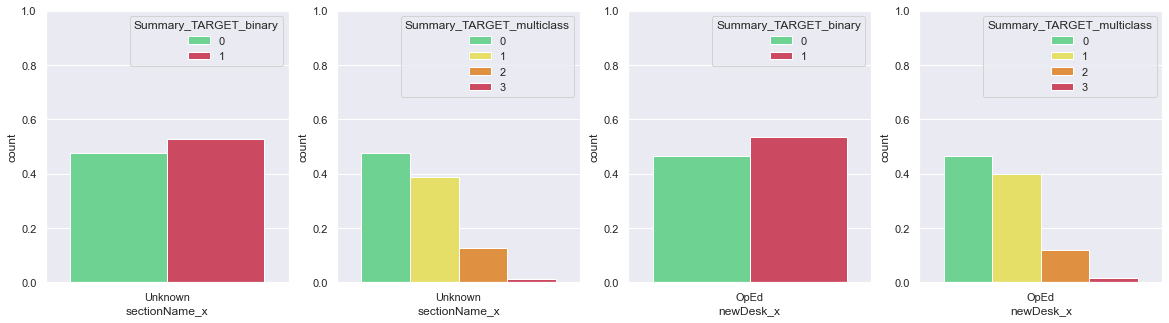

Showing controversy of comments for topics Unknown and OpEd



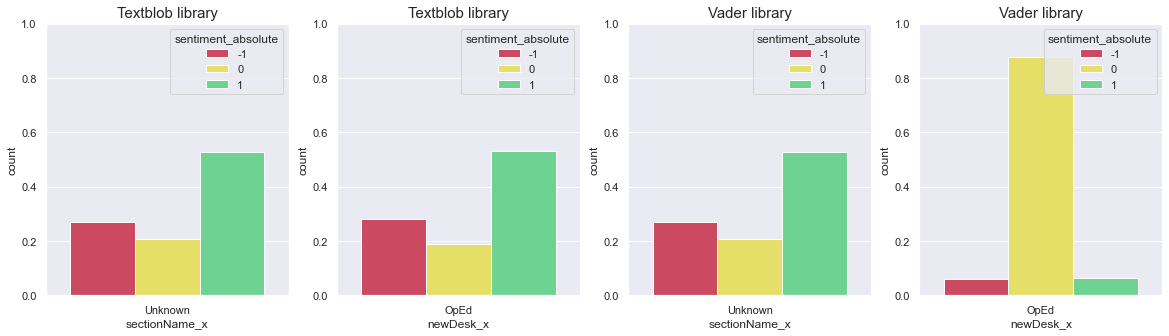

In [65]:
summary.get_summary(comment_id=22017334)